# Complete BombCell + UnitMatch Pipeline Demo

This notebook demonstrates the complete pipeline for neural spike analysis using BombCell and UnitMatch:

## 🎯 **What This Demo Does**

### Part 1: BombCell Quality Control
- Analyzes spike sorting data from Kilosort
- Extracts comprehensive quality metrics for each unit
- Classifies units as "GOOD", "MUA", "NOISE", or "NON-SOMA"  
- **Creates waveform data specifically formatted for UnitMatch**

### Part 2: UnitMatch Cross-Session Tracking
- Uses BombCell outputs to track neurons across recording sessions
- Applies machine learning to match units based on waveform features
- Provides interactive tools for manual curation
- Generates probability matrices showing match confidence

## 🔗 **Key Integration Points**
- BombCell creates `RawWaveforms/` folders that UnitMatch requires
- Special parameters optimize BombCell for UnitMatch compatibility
- Quality classifications help filter units for reliable matching
- Both tools work seamlessly with standard Kilosort outputs

## 📋 **What You Need**
- Kilosort output directories from 2+ recording sessions if you want to track across days or for 1 recording session if you want to merge units intra-session
- Access to raw `.bin` files (for waveform extraction)
- Meta files (`.meta` for SpikeGLX or `.oebin` for Open Ephys)


In [1]:
%load_ext autoreload
%autoreload 

# 📦 Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import BombCell for quality control
import bombcell as bc

# Import UnitMatch for cross-session tracking (optional - only if running Part 2)
try:
    import UnitMatchPy.bayes_functions as bf
    import UnitMatchPy.utils as util
    import UnitMatchPy.overlord as ov
    import UnitMatchPy.save_utils as su
    import UnitMatchPy.GUI as um_gui
    import UnitMatchPy.assign_unique_id as aid
    import UnitMatchPy.default_params as default_params
    UNITMATCH_AVAILABLE = True
    print("✅ BombCell and UnitMatch imported successfully")
except ImportError as e:
    UNITMATCH_AVAILABLE = False
    print("✅ BombCell imported successfully")
    print("⚠️  UnitMatch not available - please install: pip install UnitMatchPy")
    print(f"    Error: {e}")

print("🚀 Ready to analyze neural data!")

✅ ipywidgets available - interactive GUI ready
✅ BombCell and UnitMatch imported successfully
🚀 Ready to analyze neural data!


## 📁 Part 1: Configure Data Paths for BombCell

**Edit these paths to point to your actual data:**

For this demo, we'll analyze data from multiple sessions to demonstrate the complete pipeline.

In [2]:
# 📁 Configure Data Paths - Using Processing Playground Dataset

# These are the exact paths from the processing_playground for testing
# calca_302 sessions from 2023-04-19 and 2023-04-20

session_configs = [
    {
        'name': 'calca_302_2023-04-19',
        'ks_dir': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/kilosort4',
        'raw_file': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/cz_npxl_g0_t0.imec0.ap.bin',
        'meta_file': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/cz_npxl_g0_t0.imec0.ap.meta',
        'save_path': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf'
    },
    {
        'name': 'calca_302_2023-04-20', 
        'ks_dir': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/kilosort4',
        'raw_file': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/cz_npxl_g0_t0.imec0.ap.bin',
        'meta_file': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/cz_npxl_g0_t0.imec0.ap.meta',
        'save_path': r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf'
    }
]

kilosort_version = 4

print("🎯 BombCell + UnitMatch Pipeline Demo")
print("📊 Dataset: calca_302 cross-session tracking")
print(f"🔬 Sessions to analyze: {len(session_configs)}")
for i, config in enumerate(session_configs):
    print(f"   Session {i+1}: {config['name']}")
    print(f"      📁 KS: {Path(config['ks_dir']).name}")
    
print(f"\n🔧 Kilosort version: {kilosort_version}")
print("🎯 This demo will run BombCell first, then use outputs for UnitMatch tracking")

🎯 BombCell + UnitMatch Pipeline Demo
📊 Dataset: calca_302 cross-session tracking
🔬 Sessions to analyze: 2
   Session 1: calca_302_2023-04-19
      📁 KS: kilosort4
   Session 2: calca_302_2023-04-20
      📁 KS: kilosort4

🔧 Kilosort version: 4
🎯 This demo will run BombCell first, then use outputs for UnitMatch tracking


## 🧪 Part 1: Run BombCell Quality Control

**What BombCell does:**
- Analyzes each unit's waveform properties, firing patterns, and spatial characteristics
- Calculates 15+ quality metrics (amplitude, drift, contamination, etc.)
- Classifies units into categories based on quality thresholds
- **Special for UnitMatch**: Extracts 1000 raw spikes per unit (vs. standard 100)

**Key UnitMatch optimizations:**
- `detrendWaveform=False`: Preserves raw waveform shape for matching
- `nRawSpikesToExtract=1000`: More spikes = better cross-validation
- `saveMultipleRaw=True`: Saves separate waveform sets for validation

In [3]:
def run_bombcell_session(session_config):
    """Run BombCell on a single session with UnitMatch parameters"""
    
    name = session_config['name']
    ks_dir = session_config['ks_dir']
    raw_file = session_config.get('raw_file')
    meta_file = session_config.get('meta_file')
    
    # Create save path in the kilosort directory
    save_path = Path(session_config['save_path'])
    
    print(f"🔬 Analyzing session: {name}")
    print(f"   📁 Kilosort directory: {ks_dir}")
    print(f"   🗂️  Raw file: {Path(raw_file).name if raw_file else 'Not specified'}")
    print(f"   📄 Meta file: {Path(meta_file).name if meta_file else 'Not specified'}")
    print(f"   💾 Results will be saved to: {save_path}")
    
    # Check if BombCell has already been run
    existing_results = save_path / "cluster_bc_unitType.tsv"
    if existing_results.exists():
        print(f"   ✅ Found existing BombCell results - loading from disk")
        
        # Load existing results
        try:
            param, quality_metrics, unit_type_string = bc.load_bc_results(str(save_path))
            unit_type = np.array([1 if ut == 'GOOD' else 0 for ut in unit_type_string])
            
            print(f"   📊 Loaded results - Total units: {len(unit_type)}")
            
        except Exception as e:
            print(f"   ⚠️  Error loading existing results: {e}")
            print(f"   🔄 Will re-run BombCell analysis...")
            existing_results = None
    else:
        existing_results = None
    
    # Run BombCell if no existing results or loading failed
    if not existing_results or not existing_results.exists():
        print("   🚀 Running BombCell analysis...")
        quality_metrics, param, unit_type, unit_type_string = bc.run_bombcell_unit_match(
            ks_dir=ks_dir,
            save_path=str(save_path),
            raw_file=raw_file,
            meta_file=meta_file,
            kilosort_version=kilosort_version
        )
        
        print(f"   ✅ Analysis complete!")
        print(f"   📊 Total units: {len(unit_type)}")

    
    # Check UnitMatch waveforms
    raw_waveforms_dir = save_path / "RawWaveforms"
    if raw_waveforms_dir.exists():
        waveform_files = list(raw_waveforms_dir.glob("Unit*_RawSpikes.npy"))
        print(f"   🎯 UnitMatch waveforms: {len(waveform_files)} files saved")
    else:
        print(f"   ⚠️  No UnitMatch waveforms - check raw file access")
    
    return {
        'name': name,
        'ks_dir': ks_dir,
        'save_path': str(save_path),
        'quality_metrics': quality_metrics,
        'param': param,
        'unit_type': unit_type,
        'unit_type_string': unit_type_string
    }

# Run BombCell on all sessions
print("🚀 Running BombCell analysis on all sessions...")
session_results = []

for i, session_config in enumerate(session_configs):
    print(f"\n{'='*60}")
    print(f"SESSION {i+1}/{len(session_configs)}")
    print(f"{'='*60}")
    result = run_bombcell_session(session_config)
    session_results.append(result)

print(f"\n🎉 BombCell analysis complete for {len(session_results)} sessions!")

🚀 Running BombCell analysis on all sessions...

SESSION 1/2
🔬 Analyzing session: calca_302_2023-04-19
   📁 Kilosort directory: /home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/kilosort4
   🗂️  Raw file: cz_npxl_g0_t0.imec0.ap.bin
   📄 Meta file: cz_npxl_g0_t0.imec0.ap.meta
   💾 Results will be saved to: /home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf
   ✅ Found existing BombCell results - loading from disk
   📊 Loaded results - Total units: 1
   🎯 UnitMatch waveforms: 657 files saved

SESSION 2/2
🔬 Analyzing session: calca_302_2023-04-20
   📁 Kilosort directory: /home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/kilosort4
   🗂️  Raw file: cz_npxl_g0_t0.imec0.ap.bin
   📄 Meta file: cz_npxl_g0_t0.imec0.ap.meta
   💾 Results will be saved to: /home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testin

## 🎯 Part 2: UnitMatch Cross-Session Tracking

**What UnitMatch does:**
- Compares units across different recording sessions using multiple features
- Uses machine learning (Naive Bayes) to calculate match probabilities  
- Identifies the same neurons recorded on different days
- Provides tools for manual curation and validation

**This section requires multiple sessions with BombCell outputs!**

In [4]:
# 🔗 Setup UnitMatch Parameters and Paths

print("🎯 Setting up UnitMatch for cross-session tracking...")

# Get default UnitMatch parameters
um_param = default_params.get_default_param()

# Set up paths from our BombCell results
KS_dirs = [result['ks_dir'] for result in session_results]
um_param['KS_dirs'] = KS_dirs

# Set up BombCell paths - using exact paths from processing_playground
custom_bombcell_paths = [
    r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/cluster_bc_unitType.tsv',
    r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/cluster_bc_unitType.tsv'
]

custom_raw_waveform_paths = [
    r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/RawWaveforms',
    r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/RawWaveforms'
]

print(f"📁 Kilosort directories: {len(KS_dirs)}")
for i, ks_dir in enumerate(KS_dirs):
    print(f"   Session {i+1}: {Path(ks_dir).name}")

print(f"📊 BombCell unit classifications:")
for i, bc_path in enumerate(custom_bombcell_paths):
    exists = "✅" if Path(bc_path).exists() else "❌"
    print(f"   Session {i+1}: {exists} {Path(bc_path).name}")
    
print(f"🎯 Raw waveforms for UnitMatch:")
for i, wv_path in enumerate(custom_raw_waveform_paths):
    exists = "✅" if Path(wv_path).exists() else "❌"
    n_files = len(list(Path(wv_path).glob("Unit*_RawSpikes.npy"))) if Path(wv_path).exists() else 0
    print(f"   Session {i+1}: {exists} {n_files} waveform files")

# Setup UnitMatch paths - this matches exactly what processing_playground does
try:
    wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(
        KS_dirs, 
        custom_raw_waveform_paths=custom_raw_waveform_paths,
        custom_bombcell_paths=custom_bombcell_paths
    )
    
    um_param = util.get_probe_geometry(channel_pos[0], um_param)
    print("✅ UnitMatch paths configured successfully")
    UNITMATCH_READY = True
    
except Exception as e:
    print(f"❌ Error setting up UnitMatch paths: {e}")
    print("   Make sure BombCell has been run and waveforms extracted")
    UNITMATCH_READY = False

🎯 Setting up UnitMatch for cross-session tracking...
📁 Kilosort directories: 2
   Session 1: kilosort4
   Session 2: kilosort4
📊 BombCell unit classifications:
   Session 1: ✅ cluster_bc_unitType.tsv
   Session 2: ✅ cluster_bc_unitType.tsv
🎯 Raw waveforms for UnitMatch:
   Session 1: ✅ 657 waveform files
   Session 2: ✅ 644 waveform files
✅ UnitMatch paths configured successfully


In [5]:
# 🧠 Run UnitMatch Analysis Pipeline


print("🚀 Running UnitMatch cross-session analysis...")

# Step 0: Load good units and waveform data
print("📊 Step 0: Loading unit waveforms...")
waveform, session_id, session_switch, within_session, good_units, um_param = util.load_good_waveforms(
    wave_paths, unit_label_paths, um_param, good_units_only=True
) 

print(f"   ✅ Loaded {len(np.concatenate(good_units))} good units across {len(session_results)} sessions")
print(f"   📏 Waveform shape: {waveform.shape} (units × channels × time)")

# Create cluster info
clus_info = {
    'good_units': good_units, 
    'session_switch': session_switch, 
    'session_id': session_id,
    'original_ids': np.concatenate(good_units)
}

# Step 1: Extract waveform parameters
print("🔍 Step 1: Extracting waveform features...")
extracted_wave_properties = ov.extract_parameters(waveform, channel_pos, clus_info, um_param)
print("   ✅ Extracted amplitude, spatial decay, and waveform features")

# Steps 2-4: Calculate similarity metrics with drift correction
print("📐 Steps 2-4: Computing similarity metrics and drift correction...")
total_score, candidate_pairs, scores_to_include, predictors = ov.extract_metric_scores(
    extracted_wave_properties, session_switch, within_session, um_param, niter=2
)
print(f"   ✅ Found {np.sum(candidate_pairs)} candidate unit pairs")
print(f"   📊 Metrics included: {list(scores_to_include.keys())}")

# Step 5: Probability analysis using Naive Bayes
print("🧮 Step 5: Calculating match probabilities...")

# Set up priors
prior_match = 1 - (um_param['n_expected_matches'] / um_param['n_units']**2)
priors = np.array([prior_match, 1 - prior_match])

# Train Naive Bayes classifier
labels = candidate_pairs.astype(int)
cond = np.unique(labels)
parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, um_param, add_one=1)

# Calculate match probabilities
probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, um_param, cond)
output_prob_matrix = probability[:, 1].reshape(um_param['n_units'], um_param['n_units'])

print(f"   ✅ Calculated probability matrix: {output_prob_matrix.shape}")
print(f"   📈 Max probability: {np.max(output_prob_matrix):.3f}")
print(f"   📊 Mean probability: {np.mean(output_prob_matrix):.3f}")
    


🚀 Running UnitMatch cross-session analysis...
📊 Step 0: Loading unit waveforms...
   ✅ Loaded 305 good units across 2 sessions
   📏 Waveform shape: (305, 61, 384, 2) (units × channels × time)
🔍 Step 1: Extracting waveform features...
   ✅ Extracted amplitude, spatial decay, and waveform features
📐 Steps 2-4: Computing similarity metrics and drift correction...
   ✅ Found 581 candidate unit pairs
   📊 Metrics included: ['amp_score', 'spatial_decay_score', 'centroid_overlord_score', 'centroid_dist', 'waveform_score', 'trajectory_score']
🧮 Step 5: Calculating match probabilities...
Calculating the probability distributions of the metric scores
Calculating the match probabilities
   ✅ Calculated probability matrix: (305, 305)
   📈 Max probability: 1.000
   📊 Mean probability: 0.006


📈 Analyzing UnitMatch results...
The percentage of units matched to themselves is: 79.01639344262294%
The percentage of false -ve's then is: 20.98360655737706% 

The rate of miss-match(es) per expected match 0.15081967213114755
The percentage of false +ve's is 0.1086443079829948% for session 1
The percentage of false +ve's is 0.09155322028500916% for session 2

This assumes that the spike sorter has made no mistakes

🎯 Match Summary (threshold = 0.5):
   🔗 Total matches found: 475.0
   📍 Within-session matches: 188.0
   🌉 Cross-session matches: 287.0


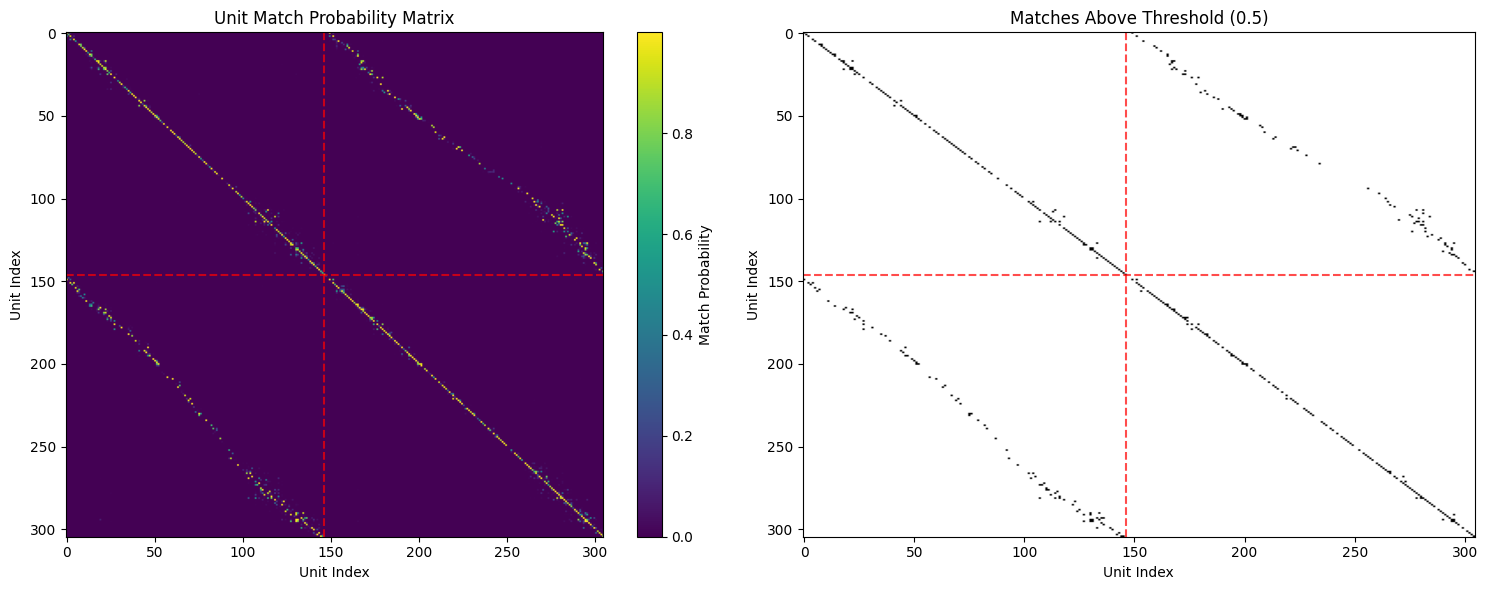

📊 Red dashed lines show session boundaries
🎯 Diagonal represents within-session matches
🌉 Off-diagonal represents cross-session matches


In [6]:
# 📊 Analyze UnitMatch Results


print("📈 Analyzing UnitMatch results...")

# Evaluate matching performance
match_threshold = um_param.get('match_threshold', 0.75)
util.evaluate_output(output_prob_matrix, um_param, within_session, session_switch, 
                    match_threshold=match_threshold)

# Create binary match matrix
output_threshold = np.zeros_like(output_prob_matrix)
output_threshold[output_prob_matrix > match_threshold] = 1

# Count matches
total_matches = np.sum(output_threshold)
within_session_matches = np.sum(output_threshold * within_session)
cross_session_matches = total_matches - within_session_matches

print(f"\n🎯 Match Summary (threshold = {match_threshold}):")
print(f"   🔗 Total matches found: {total_matches}")
print(f"   📍 Within-session matches: {within_session_matches}")
print(f"   🌉 Cross-session matches: {cross_session_matches}")

# Visualize probability matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Probability matrix
im1 = axes[0].imshow(output_prob_matrix, cmap='viridis', aspect='auto')
axes[0].set_title('Unit Match Probability Matrix')
axes[0].set_xlabel('Unit Index')
axes[0].set_ylabel('Unit Index')
plt.colorbar(im1, ax=axes[0], label='Match Probability')

# Session boundaries
n_units_cumsum = np.cumsum([0] + [len(units) for units in good_units])
for boundary in n_units_cumsum[1:-1]:
    axes[0].axhline(boundary, color='red', linestyle='--', alpha=0.7)
    axes[0].axvline(boundary, color='red', linestyle='--', alpha=0.7)

# Binary matches
im2 = axes[1].imshow(output_threshold, cmap='Greys', aspect='auto')
axes[1].set_title(f'Matches Above Threshold ({match_threshold})')
axes[1].set_xlabel('Unit Index')
axes[1].set_ylabel('Unit Index')

# Session boundaries
for boundary in n_units_cumsum[1:-1]:
    axes[1].axhline(boundary, color='red', linestyle='--', alpha=0.7)
    axes[1].axvline(boundary, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("📊 Red dashed lines show session boundaries")
print("🎯 Diagonal represents within-session matches")
print("🌉 Off-diagonal represents cross-session matches")
    


In [8]:
# 🎮 Interactive Manual Curation with UnitMatch GUI


print("🎮 Setting up interactive curation tools...")

# Prepare data for GUI - extract all the required variables
amplitude = extracted_wave_properties['amplitude']
spatial_decay = extracted_wave_properties['spatial_decay']
avg_centroid = extracted_wave_properties['avg_centroid']
avg_waveform = extracted_wave_properties['avg_waveform']
avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
wave_idx = extracted_wave_properties['good_wave_idxs']
max_site = extracted_wave_properties['max_site']
max_site_mean = extracted_wave_properties['max_site_mean']

# Process info for GUI
um_gui.process_info_for_GUI(
    output_prob_matrix, match_threshold, scores_to_include, total_score, 
    amplitude, spatial_decay, avg_centroid, avg_waveform, avg_waveform_per_tp, 
    wave_idx, max_site, max_site_mean, waveform, within_session, 
    channel_pos, clus_info, um_param
)

print("✅ GUI data prepared successfully")
print("\n🎯 To launch interactive curation:")
print("   Run: is_match, not_match, matches_GUI = um_gui.run_GUI()")
print("\n🔍 The GUI provides:")
print("   - Interactive visualization of unit pairs")
print("   - Side-by-side waveform comparisons")
print("   - Quality metric displays")
print("   - Manual accept/reject controls")
print("   - Real-time match probability updates")

print("\n💡 Curation workflow:")
print("   1. GUI shows potential matches above threshold")
print("   2. Review waveform similarity and spatial locations")
print("   3. Accept good matches, reject false positives")
print("   4. Use curated results for final unit tracking")

# Before running the GUI
from UnitMatchPy.GUI import precalculate_all_acgs

# Pre-calculate and save ACGs
acg_cache = precalculate_all_acgs(clus_info, um_param,
save_path='my_acgs.pkl')



🎮 Setting up interactive curation tools...
✅ GUI data prepared successfully

🎯 To launch interactive curation:
   Run: is_match, not_match, matches_GUI = um_gui.run_GUI()

🔍 The GUI provides:
   - Interactive visualization of unit pairs
   - Side-by-side waveform comparisons
   - Quality metric displays
   - Manual accept/reject controls
   - Real-time match probability updates

💡 Curation workflow:
   1. GUI shows potential matches above threshold
   2. Review waveform similarity and spatial locations
   3. Accept good matches, reject false positives
   4. Use curated results for final unit tracking
Pre-calculating autocorrelograms for all units...
Processed 50/305 units
Processed 100/305 units
Processed 150/305 units
Processed 200/305 units
Processed 250/305 units
Processed 300/305 units
ACG cache saved to my_acgs.pkl


In [9]:
is_match, not_match, matches_GUI = um_gui.run_GUI()
# GUI guide: https://github.com/EnnyvanBeest/UnitMatch/blob/main/UnitMatchPy/Demo%20Notebooks/GUI_Reference_Guide.md

Could not load ACG cache from acg_cache.pkl: [Errno 2] No such file or directory: 'acg_cache.pkl'
Icon path: /home/jf5479/Dropbox/Python/UnitMatch/UnitMatchPy/UnitMatchPy/GUI_icon.png
File exists: True


In [ ]:
# 💾 Save Results and Generate Final Outputs

print("💾 Saving UnitMatch results and generating final outputs...")

# Assign unique IDs to matched units across sessions
UIDs = aid.assign_unique_id(output_prob_matrix, um_param, clus_info)

# Get final matches above threshold
matches = np.argwhere(output_threshold == 1)

# Create save directory next to the first session's BombCell results
save_dir = Path(session_results[0]['save_path']).parent / "UnitMatch_Results"
save_dir.mkdir(exist_ok=True)

print(f"📁 Saving results to: {save_dir}")

# Save comprehensive UnitMatch results
su.save_to_output(
    str(save_dir), 
    scores_to_include, 
    matches,
    output_prob_matrix, 
    avg_centroid, 
    avg_waveform, 
    avg_waveform_per_tp, 
    max_site,
    total_score, 
    output_threshold, 
    clus_info, 
    um_param, 
    UIDs=UIDs, 
    matches_curated=None,  # Set to matches_curated if manual curation was performed
    save_match_table=True
)

print("✅ Results saved successfully!")

# Generate summary statistics
n_unique_neurons = len(np.unique(UIDs))
n_total_units = len(np.concatenate(good_units))
n_cross_session_matches = cross_session_matches

print(f"\n📊 Final Results Summary:")
print(f"{'='*60}")
print(f"🧠 Dataset: calca_302 (2 sessions)")
print(f"📊 Total units analyzed: {sum(len(result['unit_type']) for result in session_results)}")
print(f"✅ Good units tracked: {n_total_units}")
print(f"🔗 Cross-session matches found: {n_cross_session_matches}")
print(f"🏷️  Unique neurons identified: {n_unique_neurons}")

print(f"\n📁 Output Files Generated:")
print(f"\n📁 Output Files Generated:")
print(f"   📊 MatchProb.npy - Match probability matrix")
print(f"   📋 match_table.csv - Detailed match information")




💾 Saving UnitMatch results and generating final outputs...
Number of Liberal Matches: 67
Number of Intermediate Matches: 60
Number of Conservative Matches: 60
📁 Saving results to: /home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/UnitMatch_Results
✅ Results saved successfully!

📊 Final Results Summary:
🧠 Dataset: calca_302 (2 sessions)
📊 Total units analyzed: 2
✅ Good units tracked: 305
🔗 Cross-session matches found: 287.0
🏷️  Unique neurons identified: 305

📁 Output Files Generated:
   📊 output_prob_matrix.npy - Match probability matrix
   📋 match_table.csv - Detailed match information
   🏷️  unique_IDs.npy - Cross-session unit identifiers
   📈 total_score.npy - Combined similarity scores
   🎯 clus_info.json - Unit metadata and session info


## 🎉 Pipeline Complete!


### Key Files Generated

**BombCell Outputs (per session):**
- `qMetrics/cluster_bc_unitType.tsv` - Unit classifications
- `qMetrics/templates._bc_qMetrics.parquet` - Quality metrics
- `qMetrics/RawWaveforms/` - Raw spike waveforms for UnitMatch
- `qMetrics/summary_plots.png` - Quality control visualizations

**UnitMatch Outputs:**
- `UnitMatch_Results/output_prob_matrix.npy` - Match probabilities
- `UnitMatch_Results/match_table.csv` - Unit matches and scores
- `UnitMatch_Results/unique_IDs.npy` - Cross-session unit identifiers
